In [4]:
import xarray as xr
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from eofs.xarray import Eof
import seaborn as sns
import scipy as sp

import functions.data_wrangling as dw
import functions.eddy_feedback as ef

# Import data

In [5]:
# obtain model names from directory
dir = '/home/links/ct715/data_storage/PAMIP/processed_monthly/combined_ua_epfy_divFy/1.1_pdSST-pdSIC'
path_dir = Path(dir)
models_dir = sorted(path_dir.iterdir())
models = [model.name.split('_')[0] for model in models_dir]

# import models into dictionary
ds = {}
for model in models:
    # import data
    ds[model] = xr.open_dataset(f'{dir}/{model}_1.1_u_ubar_epfy_divFy.nc')
    # add model name to dataset
    ds[model].attrs['model'] = model

In [6]:
# Load existing CSV file if it exists
csv_file = sorted(Path('/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/efp').iterdir())[-1]
csv_path = str(csv_file)
df_exists = csv_file.exists()
num_models_csv = int(csv_file.stem.split('_')[-1])

# import dataFrame and check if models are already in the CSV
df = pd.read_csv(csv_path)
existing_models = set(df['Model'].values)


if num_models_csv == len(models):
    print(f"CSV file already exists with {num_models_csv} models.")
else:
    print(f'Models in file: {num_models_csv}. Models in directory: {len(models)}')
    
    pamip_efp_nh = {}
    pamip_efp_sh = {}
    # Only calculate for models not already in the CSV
    for model in models:
        if model in existing_models:
            print(f"Skipping {model}: already in CSV.")
            continue
        print(f"Calculating for {model}...")
        efp_nh = ef.calculate_efp(ds[model], data_type='pamip')
        efp_sh = ef.calculate_efp(ds[model], data_type='pamip', calc_south_hemis=True)
        pamip_efp_nh[model] = efp_nh
        pamip_efp_sh[model] = efp_sh

    # Append new results to dataframe if any
    if pamip_efp_nh:
        new_data = {
            'Model': pamip_efp_nh.keys(),
            'NH Feedback (DJF)': pamip_efp_nh.values(),
            'SH Feedback (JAS)': pamip_efp_sh.values()
        }
        new_df = pd.DataFrame(new_data)
        df = pd.concat([df, new_df], ignore_index=True)

        # Save updated CSV file with updated model count
        updated_num_models = len(df['Model'].unique())
        df.to_csv(f'./data/EFP_NH_SH_PAMIP_{updated_num_models}.csv', index=False)

CSV file already exists with 11 models.


# EFP NH vs SH

Plot Screen Fig2 to check that this new data is showing the results it should be.

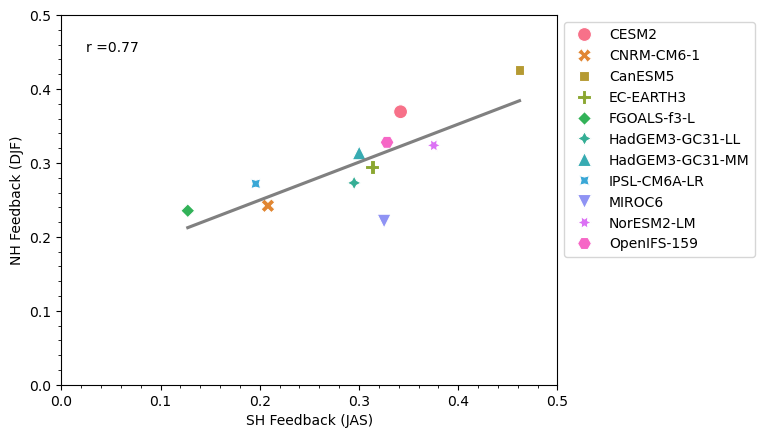

In [7]:
sns.regplot(data=df, x='SH Feedback (JAS)', y='NH Feedback (DJF)', scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None)
sns.scatterplot(data=df, x='SH Feedback (JAS)', y='NH Feedback (DJF)', hue='Model', style='Model', s=100)

# Insert Pearson's correlation
r, p = sp.stats.pearsonr(x=df['NH Feedback (DJF)'], y=df['SH Feedback (JAS)'])
ax = plt.gca()
plt.text(.05, .9, "r ={:.2f}".format(r), transform=ax.transAxes)

plt.xlim([0,0.5])
plt.ylim([0,0.5])

plt.minorticks_on()
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('./plots/NH_vs_SH_EFP_PAMIP.png')
plt.show()

# Pressure levels comparison

Number of levels between surface and model top

In [8]:
levels = {}
num_levels = {}
for model in models:
    
    levels[model] = ds[model].level.values
    num_levels[model] = len(levels[model])

pd_levels = pd.DataFrame(num_levels.values(), index=num_levels.keys(), columns=['Number of Levels'])
pd_levels

,Number of Levels
CESM2,19
CNRM-CM6-1,19
CanESM5,19
EC-EARTH3,19
FGOALS-f3-L,8
HadGEM3-GC31-LL,19
HadGEM3-GC31-MM,19
IPSL-CM6A-LR,19
MIROC6,19
NorESM2-LM,19


Number of levels between 600 and 200 hPa

In [9]:
num_levels_600_200 = {}
for model in models:
    
    levels_600_200 = ds[model].sel(level=slice(600,200))
    
    num_levels_600_200[model] = len(levels_600_200.level.values)

pd_levels_600_200 = pd.DataFrame(num_levels_600_200.values(), index=num_levels_600_200.keys(), columns=['Num levels (600-200 hPa)'])
pd_levels_600_200

,Num levels (600-200 hPa)
CESM2,6
CNRM-CM6-1,6
CanESM5,6
EC-EARTH3,6
FGOALS-f3-L,2
HadGEM3-GC31-LL,6
HadGEM3-GC31-MM,6
IPSL-CM6A-LR,6
MIROC6,6
NorESM2-LM,6


# Consistently `r=0.77`

In [10]:
df

,Model,NH Feedback (DJF),SH Feedback (JAS)
0,CESM2,0.3693,0.3419
1,CNRM-CM6-1,0.2421,0.2082
2,CanESM5,0.4256,0.4618
3,EC-EARTH3,0.2945,0.3135
4,FGOALS-f3-L,0.2354,0.1274
5,HadGEM3-GC31-LL,0.2730,0.2951
6,HadGEM3-GC31-MM,0.3137,0.3002
7,IPSL-CM6A-LR,0.2719,0.1959
8,MIROC6,0.2213,0.3253
9,NorESM2-LM,0.3238,0.3754


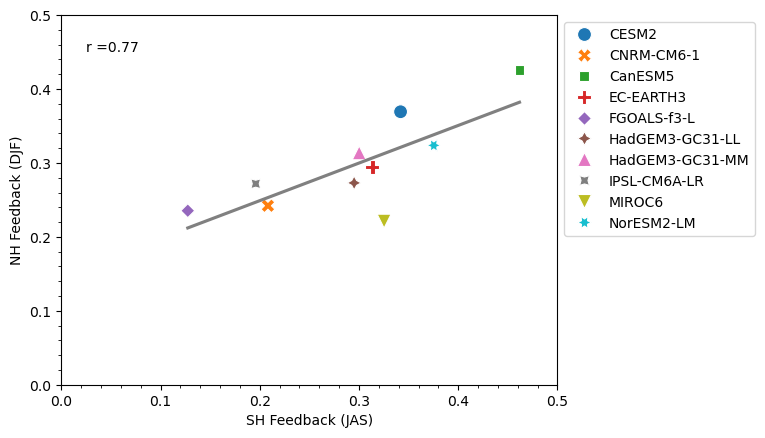

In [11]:
# Remove rows where the 'Model' column has a specific value
df = df[df['Model'] != 'OpenIFS-159']

sns.regplot(data=df, x='SH Feedback (JAS)', y='NH Feedback (DJF)', scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None)
sns.scatterplot(data=df, x='SH Feedback (JAS)', y='NH Feedback (DJF)', hue='Model', style='Model', s=100)

# Insert Pearson's correlation
r, p = sp.stats.pearsonr(x=df['NH Feedback (DJF)'], y=df['SH Feedback (JAS)'])
ax = plt.gca()
plt.text(.05, .9, "r ={:.2f}".format(r), transform=ax.transAxes)

plt.xlim([0,0.5])
plt.ylim([0,0.5])

plt.minorticks_on()
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('./plots/NH_vs_SH_EFP_PAMIP.png')
plt.show()

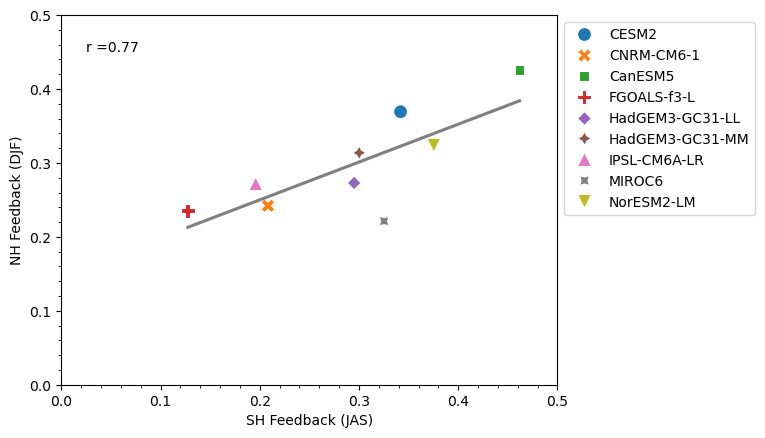

In [12]:
# Remove rows where the 'Model' column has a specific value
df = df[df['Model'] != 'EC-EARTH3']

sns.regplot(data=df, x='SH Feedback (JAS)', y='NH Feedback (DJF)', scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None)
sns.scatterplot(data=df, x='SH Feedback (JAS)', y='NH Feedback (DJF)', hue='Model', style='Model', s=100)

# Insert Pearson's correlation
r, p = sp.stats.pearsonr(x=df['NH Feedback (DJF)'], y=df['SH Feedback (JAS)'])
ax = plt.gca()
plt.text(.05, .9, "r ={:.2f}".format(r), transform=ax.transAxes)

plt.xlim([0,0.5])
plt.ylim([0,0.5])

plt.minorticks_on()
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('./plots/NH_vs_SH_EFP_PAMIP.png')
plt.show()

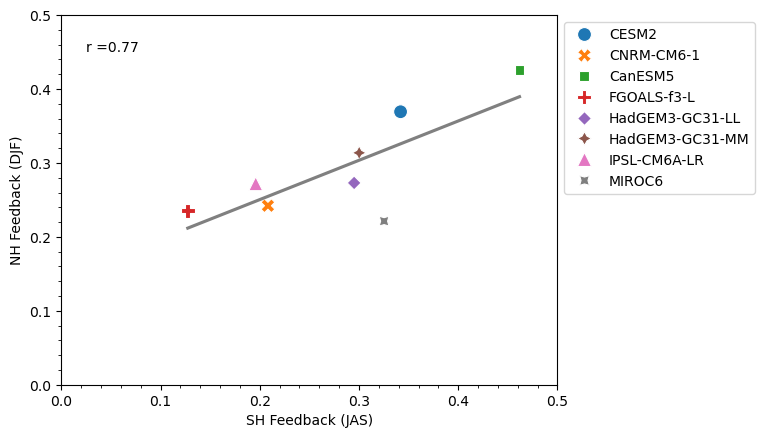

In [13]:
# Remove rows where the 'Model' column has a specific value
df = df[df['Model'] != 'NorESM2-LM']

sns.regplot(data=df, x='SH Feedback (JAS)', y='NH Feedback (DJF)', scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None)
sns.scatterplot(data=df, x='SH Feedback (JAS)', y='NH Feedback (DJF)', hue='Model', style='Model', s=100)

# Insert Pearson's correlation
r, p = sp.stats.pearsonr(x=df['NH Feedback (DJF)'], y=df['SH Feedback (JAS)'])
ax = plt.gca()
plt.text(.05, .9, "r ={:.2f}".format(r), transform=ax.transAxes)

plt.xlim([0,0.5])
plt.ylim([0,0.5])

plt.minorticks_on()
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('./plots/NH_vs_SH_EFP_PAMIP.png')
plt.show()

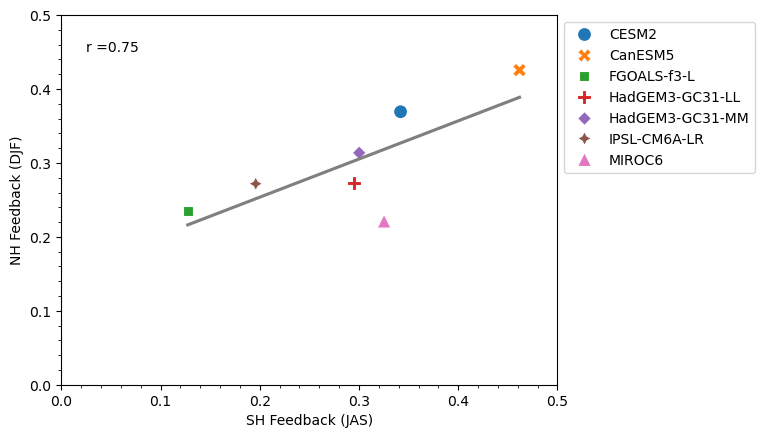

In [14]:
# Remove rows where the 'Model' column has a specific value
df = df[df['Model'] != 'CNRM-CM6-1']

sns.regplot(data=df, x='SH Feedback (JAS)', y='NH Feedback (DJF)', scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None)
sns.scatterplot(data=df, x='SH Feedback (JAS)', y='NH Feedback (DJF)', hue='Model', style='Model', s=100)

# Insert Pearson's correlation
r, p = sp.stats.pearsonr(x=df['NH Feedback (DJF)'], y=df['SH Feedback (JAS)'])
ax = plt.gca()
plt.text(.05, .9, "r ={:.2f}".format(r), transform=ax.transAxes)

plt.xlim([0,0.5])
plt.ylim([0,0.5])

plt.minorticks_on()
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('./plots/NH_vs_SH_EFP_PAMIP.png')
plt.show()